### Quick note before starting the experiment

In this experiment, crude oil prices are predicted using Random Forest, though it is generally unsuitable for trending data due to its prediction mechanism. Here, since both max and min prices appear in the training set, the Random Forest is used for HPO demonstration purposes.

# Data Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection
import sklearn.metrics
import time
from itertools import product
import random
import optuna
from IPython.core.display import Markdown
import pprint
import matplotlib.pyplot as plt

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Set verbosity to optuna.logging.INFO to see the optimisation details while running Optuna

c:\Users\armin\Projects\teachingML\teachingML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("2025-06-MD.csv")
data = data.iloc[1:, :] # Remove the Transform row (irrelevant)
data = data.drop(columns=["sasdate"]) # Remove dates (irrelevant)

In [3]:
print(f"data shape before cleaning: rows = {data.shape[0]}, columns = {data.shape[1]}")
print("-" * 100)

nan_per_col = data.isna().sum()
nan_per_col = nan_per_col[nan_per_col > 0]

print(f"Number of NaN per column:\n{nan_per_col}")
print("-" * 100)

# Trim the dataset to reduce the number of cols with NaNs
# Note: would be better to keep them and fill the missing values.
# For demonstration of hyperparameter optimisation, though, it is sufficient
data = data.iloc[12:-2, :]
nan_per_col = data.isna().sum()
nan_per_col = nan_per_col[nan_per_col > 0]

data = data.drop(columns=nan_per_col.index)

# Create label (target)
data["label"] = -1.0
data.iloc[:-1, -1] = data["OILPRICEx"][1:]
data = data.iloc[:-1]

print(data["label"])
print(data["OILPRICEx"])

print(f"data shape after cleaning and setup: rows = {data.shape[0]}, columns = {data.shape[1]}")

data shape before cleaning: rows = 797, columns = 126
----------------------------------------------------------------------------------------------------
Number of NaN per column:
CMRMTSPLx          1
HWI                1
HWIURATIO          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      2
S&P PE ratio       1
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         154
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64
----------------------------------------------------------------------------------------------------
13      2.97
14      2.97
15      2.97
16      2.97
17      2.97
       ...  
790    69.95
791    70.12
792    75.74
793    71.53
794    68.24
Name: label, Length: 782, dtype: float64
13      2.97
14      2.97
15      2.97

In [4]:
trainval_idx, test_idx = sklearn.model_selection.train_test_split(np.arange(len(data)), train_size=0.8, shuffle=False)
train_idx, val_idx = sklearn.model_selection.train_test_split(trainval_idx, train_size=0.8, shuffle=False)

X, y = data.drop(columns=["label"]), data["label"]

X_trainval, y_trainval = X.iloc[trainval_idx], y.iloc[trainval_idx]
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

print(f"Train size: {len(y_train)}, Validation size: {len(y_val)}, Test size: {len(y_test)}")

Train size: 500, Validation size: 125, Test size: 157


# Overview

Try to see how well Random Forest with different hyperparameter configurations predicts `OILPRICEx`

In [5]:
# A helper function for Overview section
def setup_and_fit_model(params: dict):
    model = RandomForestRegressor(**params)
    model.fit(X_trainval, y_trainval)

    return sklearn.metrics.root_mean_squared_error(model.predict(X_test), y_test)

In [6]:
# A very shallow model
rmse_very_shallow = setup_and_fit_model(
    {
        "n_estimators": 20,
        "max_features": "log2",
        "max_depth": 3,
        "max_leaf_nodes": 4,
        "max_samples": 0.5,
        "random_state": 4,
    }
)

# A shallow model
rmse_shallow = setup_and_fit_model(
    {
        "n_estimators": 50,
        "max_features": "log2",
        "max_depth": 6,
        "max_leaf_nodes": 8,
        "max_samples": 0.7,
        "random_state": 4,
    }
)


# Average
rmse_average = setup_and_fit_model(
    {
        "n_estimators": 100,
        "max_features": "sqrt",
        "max_depth": 12,
        "max_leaf_nodes": 12,
        "max_samples": 0.8,
        "random_state": 4,
    }
)

# A light complex model
rmse_light_complex = setup_and_fit_model(
    {
        "n_estimators": 300,
        "max_features": "sqrt",
        "max_depth": None,
        "max_leaf_nodes": None,
        "max_samples": 0.8,
        "random_state": 4,
    }
)

# A complex model
rmse_complex = setup_and_fit_model(
    {
        "n_estimators": 500,
        "max_features": 0.5,
        "max_depth": None,
        "max_leaf_nodes": None,
        "max_samples": 0.8,
        "random_state": 4,
    }
)

# A more complex model
rmse_more_complex = setup_and_fit_model(
    {
        "n_estimators": 800,
        "max_features": None,
        "max_depth": None,
        "max_leaf_nodes": None,
        "max_samples": None,
        "random_state": 4,
    }
)

# A very complex model
rmse_very_complex = setup_and_fit_model(
    {
        "n_estimators": 1200,
        "max_features": None,
        "max_depth": None,
        "max_leaf_nodes": None,
        "max_samples": None,
        "random_state": 4,
    }
)


In [7]:
print(f"Very shallow model RMSE: {rmse_very_shallow:.3f}")
print(f"Shallow model RMSE: {rmse_shallow:.3f}")
print(f"Average model RMSE: {rmse_average:.3f}")
print(f"Light complex model RMSE: {rmse_light_complex:.3f}")
print(f"Complex model RMSE: {rmse_complex:.3f}")
print(f"More complex model RMSE: {rmse_more_complex:.3f}")
print(f"Very complex model RMSE: {rmse_very_complex:.3f}")

Very shallow model RMSE: 24.419
Shallow model RMSE: 30.580
Average model RMSE: 27.676
Light complex model RMSE: 30.059
Complex model RMSE: 18.438
More complex model RMSE: 14.112
Very complex model RMSE: 14.202


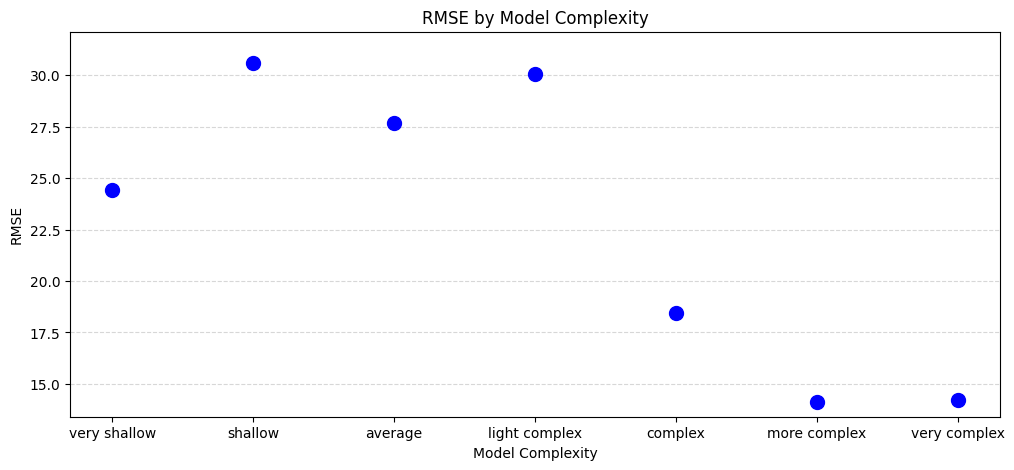

In [8]:
models = ["very shallow", "shallow", "average", "light complex", "complex", "more complex", "very complex"]
rmse_values = [rmse_very_shallow, rmse_shallow, rmse_average, rmse_light_complex, rmse_complex, rmse_more_complex, rmse_very_complex]

plt.figure(figsize=(12, 5))
plt.plot(models, rmse_values, marker="o", color="blue", markersize=10, linestyle="None")
plt.ylabel("RMSE")
plt.xlabel("Model Complexity")
plt.title("RMSE by Model Complexity")
plt.ylim(min(rmse_values)*0.95, max(rmse_values)*1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Hyperparameter Optimisation

In [9]:
# Start the timer
hpo_start_time = time.perf_counter()

In [10]:
# Some helper functions

def fit_model_and_update_best(params: dict, best_params: dict) -> None:
    params.update({"random_state": 0})
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    rmse = sklearn.metrics.root_mean_squared_error(y_val, model.predict(X_val))

    if rmse < best_params["rmse"]:
        best_params["params"] = params
        best_params["rmse"] = rmse
    
    return rmse


def perform_hpo(hpo_algo):
    start_time = time.perf_counter()

    best_params = hpo_algo()

    print(f"Algorithm runtime: {time.perf_counter() - start_time:.2f} seconds")
    print("-" * 100)
    print(f"Best parameters: {pprint.pformat(best_params["params"])},\nBest validation RMSE: {best_params['rmse']:.4f}")
    print("-" * 100)

    print("Retraining model with best params on train+val set before testing on test set...")

    model = RandomForestRegressor(**best_params["params"])
    model.fit(X_trainval, y_trainval)

    rmse = sklearn.metrics.root_mean_squared_error(y_test, model.predict(X_test))

    print(f"Test RMSE: {rmse:.4f}")
    print("-" * 100)

    return rmse

## Default hyperparameters

In [11]:
print("Running the default Random Forest model...")
print("-" * 100)

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

print(f"Val RMSE: {sklearn.metrics.root_mean_squared_error(y_val, model.predict(X_val)):.4f}")

model = RandomForestRegressor(random_state=0)
model.fit(X_trainval, y_trainval)

default_rmse = sklearn.metrics.root_mean_squared_error(y_test, model.predict(X_test))

print(f"Test RMSE: {default_rmse:.4f}")
print("Finished the default model")

Running the default Random Forest model...
----------------------------------------------------------------------------------------------------
Val RMSE: 39.5254
Test RMSE: 13.6276
Finished the default model


## Grid Search

In [12]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_features": [1.0, "log2", "sqrt"],
    "max_depth": [4, 8, None],
    "max_leaf_nodes": [4, 8, None],
    "max_samples": [0.8, 1.0],
}

def grid_search() -> dict:
    best_params = {
        "params": None,
        "rmse": float("inf")
    }

    for params in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), params))
        
        fit_model_and_update_best(params, best_params)

    return best_params

In [13]:
print("Performing Grid Search over 162 parameter combinations...")
print("-" * 100)

gs_rmse = perform_hpo(grid_search)

print("Finished Grid Search")

Performing Grid Search over 162 parameter combinations...
----------------------------------------------------------------------------------------------------
Algorithm runtime: 51.18 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 4,
 'max_features': 1.0,
 'max_leaf_nodes': 8,
 'max_samples': 1.0,
 'n_estimators': 50,
 'random_state': 0},
Best validation RMSE: 38.5452
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 12.0712
----------------------------------------------------------------------------------------------------
Finished Grid Search


## Random Search

In [14]:
param_bounds = {
    "n_estimators": (50, 150),
    "max_features": (min(np.log2(data.shape[1]), np.sqrt(data.shape[1])) / data.shape[1], 1.0),
    "max_depth": ("cat", [4, 8, None]),
    "max_leaf_nodes": ("cat", [4, 8, None]),
    "max_samples": (0.8, 1.0),
}

def build_params() -> dict:
    params = dict()

    for key, (lb, ub) in param_bounds.items():
        if isinstance(lb, int):
            params[key] = random.randint(lb, ub)
        if isinstance(lb, float):
            params[key] = random.uniform(lb, ub)
        if isinstance(lb, str):
            params[key] = random.choice(ub)
    
    return params
        

def random_search():    
    best_params = {
        "params": None,
        "rmse": float("inf")
    }

    count = 0

    while count < 200:
        params = build_params()

        fit_model_and_update_best(params, best_params)
        count += 1
    
    return best_params  

In [15]:
print("Performing Random Search for 200 trials...")

random.seed(1)
rs_rmse = perform_hpo(random_search)

print("Finished Random Search")

Performing Random Search for 200 trials...
Algorithm runtime: 83.82 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': None,
 'max_features': np.float64(0.9951283648451199),
 'max_leaf_nodes': None,
 'max_samples': 0.9444576216960892,
 'n_estimators': 50,
 'random_state': 0},
Best validation RMSE: 38.5800
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 13.5221
----------------------------------------------------------------------------------------------------
Finished Random Search


## Bayesian Optimisation (Tree-Structured Parzen Estimator)

In [16]:
def objective_tpe(trial: optuna.Trial, best_params: dict):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150, log=True),
        "max_features": trial.suggest_float("max_features", min(np.log2(data.shape[1]), np.sqrt(data.shape[1])) / data.shape[1], 1.0),
        "max_depth": trial.suggest_categorical("max_depth", [4, 8, None]),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [4, 8, None]),
        "max_samples": trial.suggest_float("max_samples", 0.8, 1.0),
    }

    return fit_model_and_update_best(params, best_params)

def tpe_search() -> dict:
    best_params = {
        "params": None,
        "rmse": float("inf"),
    }

    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=2))
    study.optimize(lambda trial: objective_tpe(trial, best_params), n_trials=200)

    return best_params

In [17]:
print("Performing TPE Search for 200 trials...")

tpe_rmse = perform_hpo(tpe_search)

print("Finished TPE Search")

Performing TPE Search for 200 trials...
Algorithm runtime: 120.97 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 8,
 'max_features': 0.9996696100207416,
 'max_leaf_nodes': 8,
 'max_samples': 0.9205974693806507,
 'n_estimators': 94,
 'random_state': 0},
Best validation RMSE: 38.6915
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 13.2710
----------------------------------------------------------------------------------------------------
Finished TPE Search


## Hyperband

In [18]:
param_grid = {
    "max_features": [1.0, "log2", "sqrt"],
    "max_depth": [4, 8, None],
    "max_leaf_nodes": [4, 8, None],
    "max_samples": [0.8, 1.0],
}

def objective_hb(trial: optuna.Trial, best_params: dict, min_estimators, max_estimators, step):
    params = {
        "max_features": trial.suggest_categorical("max_features", [1.0, "log2", "sqrt"]),
        "max_depth": trial.suggest_categorical("max_depth", [4, 8, None]),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [4, 8, None]),
        "max_samples": trial.suggest_categorical("max_samples", [0.8, 1.0]),
    }

    for n_estimators in range(min_estimators, max_estimators + 1, step):
        params.update({"n_estimators": n_estimators})
        rmse = fit_model_and_update_best(params, best_params)

        trial.report(rmse, n_estimators)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return rmse

def hb_grid_search() -> dict:
    best_params = {
        "params": None,
        "rmse": float("inf"),
    }
    min_estimators, max_estimators, step = 50, 150, 25

    study = optuna.create_study(
        sampler=optuna.samplers.GridSampler(search_space=param_grid),
        pruner=optuna.pruners.HyperbandPruner(
            min_resource=min_estimators,
            max_resource=max_estimators,
            reduction_factor=6,
        ),
    )
    study.optimize(
        lambda trial: objective_hb(trial, best_params, min_estimators, max_estimators, step),
        n_trials=200,
    )

    return best_params

In [19]:
print("Performing Hyperband Grid Search for 200 trials...")

hb_rmse = perform_hpo(hb_grid_search)

print("Finished Hyperband Grid Search Search")

Performing Hyperband Grid Search for 200 trials...
Algorithm runtime: 36.95 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 4,
 'max_features': 1.0,
 'max_leaf_nodes': 8,
 'max_samples': 1.0,
 'n_estimators': 150,
 'random_state': 0},
Best validation RMSE: 38.5452
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 12.4889
----------------------------------------------------------------------------------------------------
Finished Hyperband Grid Search Search


## Simulated Annealing

In [20]:
class SimulatedAnnealingSampler(optuna.samplers.BaseSampler):
    def __init__(self, temperature=100, cooldown_factor=0.9, neighbor_range_factor=0.1, seed=None):
        self._rng = np.random.RandomState(seed)
        self._independent_sampler = optuna.samplers.RandomSampler(seed=seed)
        self._temperature = temperature
        self.cooldown_factor = cooldown_factor
        self.neighbor_range_factor = neighbor_range_factor
        self._current_trial = None

    def infer_relative_search_space(self, study, trial):
        return optuna.search_space.intersection_search_space(study.trials)

    def sample_relative(self, study, trial, search_space):
        if search_space == {}:
            return {}

        prev_trial = self._get_last_complete_trial(study)

        if self._rng.uniform(0, 1) <= self._transition_probability(study, prev_trial):
            self._current_trial = prev_trial

        params = self._sample_neighbor_params(search_space)

        self._temperature *= self.cooldown_factor

        return params

    def _sample_neighbor_params(self, search_space):
        params = {}
        for param_name, param_distribution in search_space.items():
            if isinstance(param_distribution, optuna.distributions.FloatDistribution):
                assert param_distribution.step is None, "step is not supported"
                assert not param_distribution.log, "log is not supported"

                current_value = self._current_trial.params[param_name]
                width = (
                    param_distribution.high - param_distribution.low
                ) * self.neighbor_range_factor
                neighbor_low = max(current_value - width, param_distribution.low)
                neighbor_high = min(current_value + width, param_distribution.high)
                params[param_name] = self._rng.uniform(neighbor_low, neighbor_high)
            elif isinstance(param_distribution, optuna.distributions.IntDistribution):
                assert not param_distribution.log, "log is not supported"
                assert param_distribution.step == 1, "only default step == 1 is supported"

                current_value = self._current_trial.params[param_name]
                width = int((param_distribution.high - param_distribution.low) * self.neighbor_range_factor)
                neighbor_low = max(current_value - width, param_distribution.low)
                neighbor_high = min(current_value + width, param_distribution.high)
                params[param_name] = self._rng.randint(neighbor_low, neighbor_high+1)
            elif isinstance(param_distribution, optuna.distributions.CategoricalDistribution):
                # This assumes that we have "ordered categorical".
                current_value = self._current_trial.params[param_name]
                choices = param_distribution.choices
                # Not the most efficient implementation, but since we have at most 5 categoricals, it will suffice
                curr_idx = param_distribution.choices.index(current_value)
                width = max(1, int(len(choices) * self.neighbor_range_factor))
                neighbor_low = max(curr_idx - width, 0)
                neighbor_high = min(curr_idx + width, len(choices) - 1)
                # Another problem: always has a random choice between 3. Does not settle for one of them
                chosen_idx = self._rng.randint(neighbor_low, neighbor_high+1)
                params[param_name] = choices[chosen_idx]
            else:
                raise NotImplementedError(
                    "Unsupported distribution {}.".format(param_distribution)
                )

        return params

    def _transition_probability(self, study, prev_trial):
        if self._current_trial is None:
            return 1.0

        prev_value = prev_trial.value
        current_value = self._current_trial.value

        if study.direction == optuna.study.StudyDirection.MINIMIZE and prev_value <= current_value:
            return 1.0
        elif study.direction == optuna.study.StudyDirection.MAXIMIZE and prev_value >= current_value:
            return 1.0

        return np.exp(-abs(current_value - prev_value) / self._temperature)

    @staticmethod
    def _get_last_complete_trial(study):
        complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
        return complete_trials[-1]

    def sample_independent(self, study, trial, param_name, param_distribution):
        return self._independent_sampler.sample_independent(
            study, trial, param_name, param_distribution
        )


In [21]:
def objective_sa(trial: optuna.Trial, best_params: dict):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_features": trial.suggest_float("max_features", min(np.log2(data.shape[1]), np.sqrt(data.shape[1])) / data.shape[1], 1.0),
        "max_depth": trial.suggest_categorical("max_depth", [4, 8, None]),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [4, 8, None]),
        "max_samples": trial.suggest_float("max_samples", 0.8, 1.0),
    }

    return fit_model_and_update_best(params, best_params)

def sa_search() -> dict:
    best_params = {
        "params": None,
        "rmse": float("inf"),
    }

    study = optuna.create_study(sampler=SimulatedAnnealingSampler(seed=4))
    study.optimize(lambda trial: objective_sa(trial, best_params), n_trials=200)

    return best_params

In [22]:
print("Performing Simulated Annealing for 200 trials...")

sa_rmse = perform_hpo(sa_search)

print("Finished Simulated Annealing Search")

Performing Simulated Annealing for 200 trials...
Algorithm runtime: 133.35 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': None,
 'max_features': 0.9881299065384862,
 'max_leaf_nodes': 8,
 'max_samples': 0.9418035256319053,
 'n_estimators': 90,
 'random_state': 0},
Best validation RMSE: 38.7231
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 13.8030
----------------------------------------------------------------------------------------------------
Finished Simulated Annealing Search


## Genetic Algorithm

In [23]:
def objective_ga(trial: optuna.Trial, best_params: dict):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_features": trial.suggest_float("max_features", min(np.log2(data.shape[1]), np.sqrt(data.shape[1])) / data.shape[1], 1.0),
        "max_depth": trial.suggest_categorical("max_depth", [4, 8, None]),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [4, 8, None]),
        "max_samples": trial.suggest_float("max_samples", 0.8, 1.0),
    }

    return fit_model_and_update_best(params, best_params)

def ga_search() -> dict:
    best_params = {
        "params": None,
        "rmse": float("inf"),
    }

    study = optuna.create_study(sampler=optuna.samplers.NSGAIIISampler(seed=4))
    study.optimize(lambda trial: objective_ga(trial, best_params), n_trials=200)

    return best_params

In [24]:
print("Performing Genetic Algorithm for 200 trials...")

ga_rmse = perform_hpo(ga_search)

print("Finished Genetic Algorithm")

Performing Genetic Algorithm for 200 trials...


C:\Users\armin\AppData\Local\Temp\ipykernel_29180\282285672.py:18: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  study = optuna.create_study(sampler=optuna.samplers.NSGAIIISampler(seed=4))


Algorithm runtime: 107.71 seconds
----------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 8,
 'max_features': 0.95914791112792,
 'max_leaf_nodes': 8,
 'max_samples': 0.9201485442755539,
 'n_estimators': 54,
 'random_state': 0},
Best validation RMSE: 38.6568
----------------------------------------------------------------------------------------------------
Retraining model with best params on train+val set before testing on test set...
Test RMSE: 13.2240
----------------------------------------------------------------------------------------------------
Finished Genetic Algorithm


# Summary

In [25]:
display(Markdown(f"""
### Final RMSE Values
{'-'*100}  
| Algorithm                             | Test RMSE                |
|-------------------------------------|-------------------------:|
| **Default**                         | {default_rmse:.3f}  | 
| **Grid Search**                     | {gs_rmse:.3f}      |
| **Random Search**                   | {rs_rmse:.3f}       |
| **Tree-Structured Parzen Estimator**| {tpe_rmse:.3f}      |
| **Hyperband Grid Search**           | {hb_rmse:.3f}       |
| **Simulated Annealing**             | {sa_rmse:.3f}      |
| **Genetic Algorithm**               | {ga_rmse:.3f}       |
{'-'*100}
**Total HPO Runtime:** `{time.perf_counter() - hpo_start_time:.2f}` seconds
"""))


### Final RMSE Values
----------------------------------------------------------------------------------------------------  
| Algorithm                             | Test RMSE                |
|-------------------------------------|-------------------------:|
| **Default**                         | 13.628  | 
| **Grid Search**                     | 12.071      |
| **Random Search**                   | 13.522       |
| **Tree-Structured Parzen Estimator**| 13.271      |
| **Hyperband Grid Search**           | 12.489       |
| **Simulated Annealing**             | 13.803      |
| **Genetic Algorithm**               | 13.224       |
----------------------------------------------------------------------------------------------------
**Total HPO Runtime:** `542.62` seconds


# Exercises:

1. Compare Grid Search and Hyperband Grid Search. What is the key thing you observe in the final parameter selection and final MSE? What determined the difference in RMSE between the two HPO algorithms?

2. Observe that Simulated Annealing performed worse than Default on the test set. Does that mean that it is better to use a Defaut model and skip Simulated Annealing? Hint: consider the RMSE values on validation set.

3. What would you use to ensure more robust results?

4. Try this experiment with a neural network of your choice.